In [1]:

# Ячейка 1: Заголовок и описание проекта
"""
# Sentiment Analysis with LSTM - Обучение модели

## Описание проекта
Этот ноутбук демонстрирует полный процесс создания и обучения модели для анализа тональности отзывов на фильмы IMDB.

## Цели:
- Предобработать текстовые данные
- Создать и обучить LSTM модель
- Оценить качество модели
- Сохранить результаты

## Датасет: IMDB Movie Reviews (50,000 отзывов)
## Архитектура: Bidirectional LSTM
## Ожидаемая точность: ~89%
"""

# %%

'\n# Sentiment Analysis with LSTM - Обучение модели\n\n## Описание проекта\nЭтот ноутбук демонстрирует полный процесс создания и обучения модели для анализа тональности отзывов на фильмы IMDB.\n\n## Цели:\n- Предобработать текстовые данные\n- Создать и обучить LSTM модель\n- Оценить качество модели\n- Сохранить результаты\n\n## Датасет: IMDB Movie Reviews (50,000 отзывов)\n## Архитектура: Bidirectional LSTM\n## Ожидаемая точность: ~89%\n'

In [2]:
# Ячейка 2: Импорты и настройка окружения
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
import pickle
from tqdm import tqdm
import logging
import os
import re
import nltk
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Настройка для воспроизводимости результатов
torch.manual_seed(1337)
np.random.seed(1337)

# Настройка matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Все библиотеки загружены успешно!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# %%

 Все библиотеки загружены успешно!
 PyTorch version: 2.8.0+cu128
 CUDA available: True
 GPU: NVIDIA GeForce RTX 2060


In [3]:
# Ячейка 3: Загрузка и проверка NLTK данных
try:
    nltk.data.find('corpora/wordnet')
    print("NLTK wordnet уже загружен")
except LookupError:
    print("Загружаем NLTK данные...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    print("NLTK данные загружены")

# %%

 Загружаем NLTK данные...
 NLTK данные загружены


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kerio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kerio\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
# Ячейка 4: Конфигурация проекта
class Config:
    """Конфигурация проекта"""
    # Пути к файлам
    DATA_PATH = "data/raw/IMDB Dataset.csv"
    MODEL_SAVE_PATH = "models/best_model.pth"
    VOCAB_SAVE_PATH = "data/processed/vocabulary.pkl"
    RESULTS_PATH = "results/"
    
    # Параметры модели
    MAX_VOCAB_SIZE = 15000
    MAX_SEQUENCE_LENGTH = 300
    EMBEDDING_DIM = 128
    HIDDEN_DIM = 256
    NUM_LAYERS = 2
    DROPOUT = 0.3
    BIDIRECTIONAL = True
    
    # Параметры обучения
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    EPOCHS = 10
    WEIGHT_DECAY = 1e-5
    
    # Разделение данных
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Early stopping
    PATIENCE = 5
    
    # Устройство
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print("⚙️ Конфигурация проекта:")
for attr_name in dir(config):
    if not attr_name.startswith('_'):
        print(f"   {attr_name}: {getattr(config, attr_name)}")

# %%

⚙️ Конфигурация проекта:
   BATCH_SIZE: 64
   BIDIRECTIONAL: True
   DATA_PATH: data/raw/IMDB Dataset.csv
   DEVICE: cuda
   DROPOUT: 0.3
   EMBEDDING_DIM: 128
   EPOCHS: 10
   HIDDEN_DIM: 256
   LEARNING_RATE: 0.001
   MAX_SEQUENCE_LENGTH: 300
   MAX_VOCAB_SIZE: 15000
   MODEL_SAVE_PATH: models/best_model.pth
   NUM_LAYERS: 2
   PATIENCE: 5
   RANDOM_STATE: 42
   RESULTS_PATH: results/
   TEST_SIZE: 0.2
   VAL_SIZE: 0.2
   VOCAB_SAVE_PATH: data/processed/vocabulary.pkl
   WEIGHT_DECAY: 1e-05


In [5]:
# Ячейка 5: Создание директорий проекта
def create_project_directories():
    """Создает необходимые директории для проекта"""
    directories = [
        "data/raw",
        "data/processed", 
        "models",
        "results/plots",
        "results/reports",
        "results/metrics"
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"Создана директория: {directory}")

create_project_directories()

# %%

 Создана директория: data/raw
 Создана директория: data/processed
 Создана директория: models
 Создана директория: results/plots
 Создана директория: results/reports
 Создана директория: results/metrics


In [6]:
# Ячейка 6: Класс для предобработки данных
class DataPreprocessor:
    """Класс для предобработки текстовых данных"""
    
    def __init__(self, max_vocab_size=15000, max_len=300):
        self.max_vocab_size = max_vocab_size
        self.max_len = max_len
        self.lemmatizer = WordNetLemmatizer()
        self.word2idx = None
        self.idx2word = None
        
    def clean_and_lemmatize_text(self, text):
        """Очистка и лемматизация текста"""
        if pd.isna(text):
            return ""
        
        # Очистка от HTML тегов и специальных символов
        text = re.sub(r'<br\s*/>', ' ', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower().strip()
        
        # Лемматизация
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in text.split()]
        return ' '.join(lemmatized_words)
    
    def build_vocabulary(self, texts):
        """Построение словаря"""
        all_words = ' '.join(texts).split()
        word_counts = Counter(all_words)
        
        vocab = [word for word, count in word_counts.most_common(self.max_vocab_size - 2)]
        
        self.word2idx = {word: i + 2 for i, word in enumerate(vocab)}
        self.word2idx['<PAD>'] = 0
        self.word2idx['<UNK>'] = 1
        
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        logger.info(f"Словарь построен. Размер: {len(self.word2idx)}")
        return self.word2idx
    
    def encode_text(self, text):
        """Кодирование текста в числовую последовательность"""
        tokens = text.split()
        encoded = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        
        if len(encoded) > self.max_len:
            encoded = encoded[:self.max_len]
        else:
            encoded.extend([self.word2idx['<PAD>']] * (self.max_len - len(encoded)))
            
        return encoded
    
    def save_vocabulary(self, path):
        """Сохранение словаря"""
        with open(path, 'wb') as f:
            pickle.dump({
                'word2idx': self.word2idx,
                'idx2word': self.idx2word,
                'max_len': self.max_len
            }, f)
        logger.info(f"Словарь сохранен в {path}")

print("Класс DataPreprocessor создан")

# %%

 Класс DataPreprocessor создан


In [7]:
# Ячейка 7: Класс Dataset для PyTorch
class SentimentDataset(Dataset):
    """Датасет для анализа тональности"""
    
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

print("Класс SentimentDataset создан")

# %%

 Класс SentimentDataset создан


In [8]:
# Ячейка 8: Архитектура модели LSTM
class ImprovedSentimentLSTM(nn.Module):
    """Улучшенная модель LSTM для анализа тональности"""
    
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, 
                 num_layers=2, dropout=0.3, bidirectional=True):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # Embedding слой
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM слой
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Классификационная голова
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_output_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Инициализация весов
        self._init_weights()
    
    def _init_weights(self):
        """Инициализация весов"""
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    
    def forward(self, x):
        embedded = self.embedding(x)
        
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Используем последнее скрытое состояние
        if self.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        # Классификация
        output = self.dropout(hidden)
        output = torch.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output.squeeze(1)

print("Класс ImprovedSentimentLSTM создан")

# %%

 Класс ImprovedSentimentLSTM создан


In [9]:
# Ячейка 9: Класс для обучения модели
class SentimentTrainer:
    """Класс для обучения модели"""
    
    def __init__(self, model, device=None):
        self.device = device or config.DEVICE
        self.model = model.to(self.device)
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def train_epoch(self, dataloader, optimizer, criterion):
        """Обучение на одной эпохе"""
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        progress_bar = tqdm(dataloader, desc="Training", leave=False)
        
        for texts, labels in progress_bar:
            texts, labels = texts.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            predictions = self.model(texts)
            loss = criterion(predictions, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            pred_labels = torch.round(torch.sigmoid(predictions))
            correct_predictions += (pred_labels == labels).sum().item()
            total_predictions += labels.size(0)
            
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{correct_predictions/total_predictions:.4f}'
            })
        
        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_predictions
        
        return avg_loss, accuracy
    
    def evaluate(self, dataloader, criterion):
        """Оценка модели"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for texts, labels in tqdm(dataloader, desc="Evaluating", leave=False):
                texts, labels = texts.to(self.device), labels.to(self.device)
                
                predictions = self.model(texts)
                loss = criterion(predictions, labels)
                total_loss += loss.item()
                
                pred_probs = torch.sigmoid(predictions)
                pred_labels = torch.round(pred_probs)
                
                all_predictions.extend(pred_labels.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(dataloader)
        accuracy = sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
        
        return avg_loss, accuracy, all_predictions, all_labels
    
    def train(self, train_loader, val_loader, epochs=10, lr=0.001):
        """Полный цикл обучения"""
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=config.WEIGHT_DECAY)
        criterion = nn.BCEWithLogitsLoss()
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        print(f" Начинаем обучение на {self.device}")
        print(f" Параметров в модели: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(epochs):
            print(f"\n Эпоха {epoch+1}/{epochs}")
            print("-" * 50)
            
            # Обучение
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            
            # Валидация
            val_loss, val_acc, _, _ = self.evaluate(val_loader, criterion)
            
            # Сохранение метрик
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), config.MODEL_SAVE_PATH)
                print(f"Новая лучшая модель сохранена! Val Loss: {val_loss:.4f}")
            else:
                patience_counter += 1
                if patience_counter >= config.PATIENCE:
                    print("  Early stopping triggered")
                    break
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
        print("\n Обучение завершено!")
    
    def plot_training_history(self, save_path=None):
        """Визуализация процесса обучения"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        epochs = range(1, len(self.train_losses) + 1)
        
        # График потерь
        ax1.plot(epochs, self.train_losses, 'bo-', label='Train Loss', linewidth=2)
        ax1.plot(epochs, self.val_losses, 'ro-', label='Validation Loss', linewidth=2)
        ax1.set_title('Потери во время обучения', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Эпоха')
        ax1.set_ylabel('Потери')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # График точности
        ax2.plot(epochs, self.train_accuracies, 'bo-', label='Train Accuracy', linewidth=2)
        ax2.plot(epochs, self.val_accuracies, 'ro-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Точность во время обучения', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Эпоха')
        ax2.set_ylabel('Точность')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен: {save_path}")
        
        plt.show()

print("Класс SentimentTrainer создан")

# %%

 Класс SentimentTrainer создан


In [10]:
# Ячейка 10: Вспомогательные функции
def analyze_predictions(y_true, y_pred, class_names=['Negative', 'Positive'], save_path=None):
    """Анализ предсказаний модели"""
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Количество предсказаний'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Предсказанный класс', fontsize=12)
    plt.ylabel('Истинный класс', fontsize=12)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion Matrix сохранена: {save_path}")
    
    plt.show()
    
    # Отчет о классификации
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print("\n Отчет о классификации:")
    print("=" * 60)
    print(report)
    
    return report

def predict_sentiment(text, model, preprocessor, device):
    """Предсказание тональности для нового текста"""
    model.eval()
    
    # Предобработка
    cleaned_text = preprocessor.clean_and_lemmatize_text(text)
    encoded_text = preprocessor.encode_text(cleaned_text)
    
    # Преобразование в тензор
    input_tensor = torch.tensor([encoded_text], dtype=torch.long).to(device)
    
    with torch.no_grad():
        logit = model(input_tensor)
        probability = torch.sigmoid(logit).item()
    
    sentiment = "Positive" if probability > 0.5 else "Negative"
    confidence = probability if probability > 0.5 else 1 - probability
    
    return sentiment, confidence

def save_model_config(config_path, model, preprocessor, metrics):
    """Сохранение конфигурации модели"""
    config_data = {
        "model_name": "ImprovedSentimentLSTM",
        "vocab_size": len(preprocessor.word2idx),
        "embedding_dim": config.EMBEDDING_DIM,
        "hidden_dim": config.HIDDEN_DIM,
        "num_layers": config.NUM_LAYERS,
        "dropout": config.DROPOUT,
        "bidirectional": config.BIDIRECTIONAL,
        "max_sequence_length": config.MAX_SEQUENCE_LENGTH,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE,
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "metrics": metrics
    }
    
    with open(config_path, 'w') as f:
        import json
        json.dump(config_data, f, indent=2, default=str)
    
    print(f"Конфигурация модели сохранена: {config_path}")

print("Вспомогательные функции созданы")

# %%

 Вспомогательные функции созданы


Загружаем данные...
Загружено 50000 примеров
Форма датасета: (50000, 2)
Колонки: ['review', 'sentiment']

Распределение классов:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Примеры данных:

--- Пример 1 ---
Отзыв: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Тональность: positive

--- Пример 2 ---
Отзыв: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...
Тональность: positive


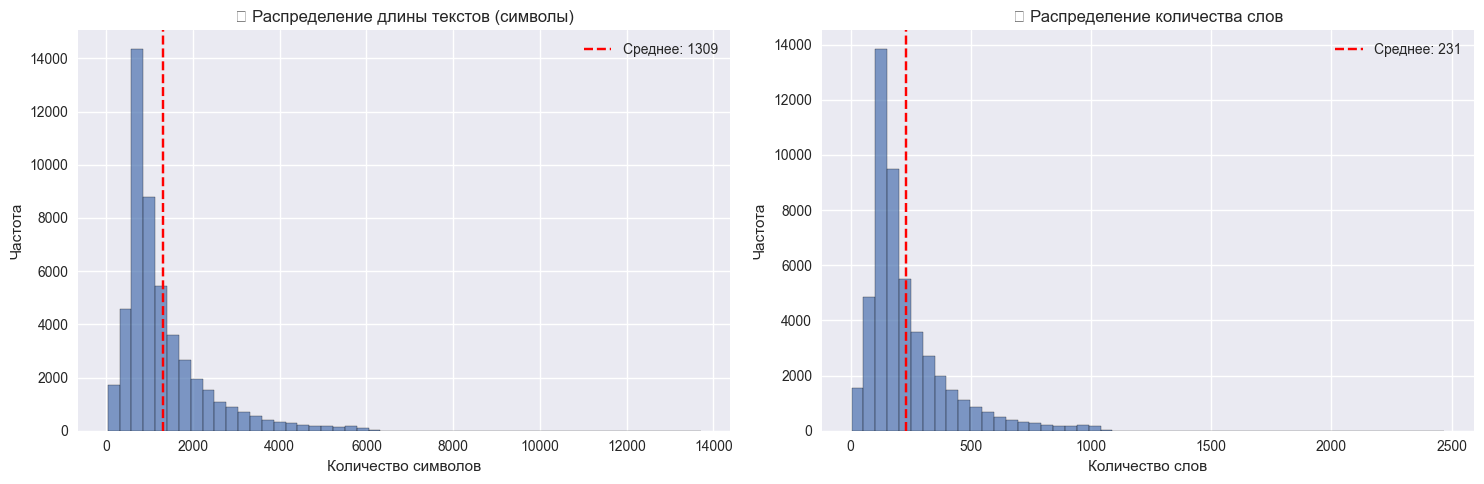


📊 Статистика длины текстов:
   Среднее количество символов: 1309
   Среднее количество слов: 231
   Максимальное количество слов: 2470
   95-й процентиль по словам: 590


In [12]:
# Ячейка 11: Загрузка и исследование данных
def load_and_explore_data(data_path):
    """Загрузка и первичный анализ данных"""
    
    # Проверка существования файла
    if not os.path.exists(data_path):
        print(f"Файл {data_path} не найден!")
        print("Скачайте датасет IMDB с Kaggle:")
        print("https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
        return None
    
    # Загрузка данных
    print("Загружаем данные...")
    df = pd.read_csv(data_path)
    
    print(f"Загружено {len(df)} примеров")
    print(f"Форма датасета: {df.shape}")
    print(f"Колонки: {list(df.columns)}")
    
    # Базовая статистика
    print("\n Распределение классов:")
    print(df['sentiment'].value_counts())
    
    print("\n Примеры данных:")
    for i in range(2):
        print(f"\n--- Пример {i+1} ---")
        print(f"Отзыв: {df.iloc[i]['review'][:200]}...")
        print(f"Тональность: {df.iloc[i]['sentiment']}")
    
    # Анализ длины текстов
    df['text_length'] = df['review'].str.len()
    df['word_count'] = df['review'].str.split().str.len()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Распределение длины символов
    ax1.hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black')
    ax1.set_title('Распределение длины текстов (символы)')
    ax1.set_xlabel('Количество символов')
    ax1.set_ylabel('Частота')
    ax1.axvline(df['text_length'].mean(), color='red', linestyle='--', 
                label=f'Среднее: {df["text_length"].mean():.0f}')
    ax1.legend()
    
    # Распределение количества слов
    ax2.hist(df['word_count'], bins=50, alpha=0.7, edgecolor='black')
    ax2.set_title('Распределение количества слов')
    ax2.set_xlabel('Количество слов')
    ax2.set_ylabel('Частота')
    ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', 
                label=f'Среднее: {df["word_count"].mean():.0f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n Статистика длины текстов:")
    print(f"   Среднее количество символов: {df['text_length'].mean():.0f}")
    print(f"   Среднее количество слов: {df['word_count'].mean():.0f}")
    print(f"   Максимальное количество слов: {df['word_count'].max()}")
    print(f"   95-й процентиль по словам: {df['word_count'].quantile(0.95):.0f}")
    
    return df

# Загружаем данные
df = load_and_explore_data(config.DATA_PATH)

# %%

In [13]:
# Ячейка 12: Предобработка данных
if df is not None:
    print("Начинаем предобработку данных...")
    
    # Создаем препроцессор
    preprocessor = DataPreprocessor(
        max_vocab_size=config.MAX_VOCAB_SIZE, 
        max_len=config.MAX_SEQUENCE_LENGTH
    )
    
    # Очистка и лемматизация
    print("Очистка и лемматизация текстов...")
    df['review_cleaned'] = df['review'].apply(preprocessor.clean_and_lemmatize_text)
    
    # Преобразование меток
    df['sentiment_numeric'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
    
    # Показываем примеры предобработки
    print("\n Примеры предобработки:")
    for i in range(2):
        print(f"\n--- Пример {i+1} ---")
        print(f"Оригинал: {df.iloc[i]['review'][:100]}...")
        print(f"Очищенный: {df.iloc[i]['review_cleaned'][:100]}...")
        print(f"Тональность: {df.iloc[i]['sentiment']} → {df.iloc[i]['sentiment_numeric']}")
    
    print(f"\n Предобработка завершена!")
else:
    print("Не удалось загрузить данные. Проверьте путь к файлу.")

# %%

Начинаем предобработку данных...
Очистка и лемматизация текстов...

Примеры предобработки:

--- Пример 1 ---
Оригинал: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Очищенный: one of the other reviewer ha mentioned that after watching just oz episode youll be hooked they are ...
Тональность: positive → 1

--- Пример 2 ---
Оригинал: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B...
Очищенный: a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and g...
Тональность: positive → 1

Предобработка завершена!


In [14]:
# Ячейка 13: Разделение данных и создание словаря
if df is not None:
    print("Разделяем данные на train/val/test...")
    
    # Разделение на train и test
    train_df, test_df = train_test_split(
        df, 
        test_size=config.TEST_SIZE, 
        random_state=config.RANDOM_STATE, 
        stratify=df['sentiment_numeric']
    )
    
    # Разделение train на train и validation
    train_df, val_df = train_test_split(
        train_df, 
        test_size=config.VAL_SIZE, 
        random_state=config.RANDOM_STATE, 
        stratify=train_df['sentiment_numeric']
    )
    
    print(f"Размеры выборок:")
    print(f"   Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"   Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"   Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
    
    # Построение словаря только на тренировочных данных
    print("\n📚 Построение словаря...")
    preprocessor.build_vocabulary(train_df['review_cleaned'].tolist())
    
    # Сохранение словаря
    preprocessor.save_vocabulary(config.VOCAB_SAVE_PATH)
    
    print(f"   Статистика словаря:")
    print(f"   Размер словаря: {len(preprocessor.word2idx)}")
    print(f"   Специальные токены: <PAD>, <UNK>")
    print(f"   Максимальная длина последовательности: {config.MAX_SEQUENCE_LENGTH}")
    
    # Примеры самых частых слов
    word_freq = Counter()
    for text in train_df['review_cleaned']:
        word_freq.update(text.split())
    
    print(f"\n Топ-10 самых частых слов:")
    for word, freq in word_freq.most_common(10):
        print(f"   '{word}': {freq}")

# %%

Разделяем данные на train/val/test...
Размеры выборок:
   Train: 32000 (64.0%)
   Validation: 8000 (16.0%)
   Test: 10000 (20.0%)

Построение словаря...


2025-09-24 12:05:06,013 - INFO - Словарь построен. Размер: 15000
2025-09-24 12:05:06,112 - INFO - Словарь сохранен в data/processed/vocabulary.pkl


Статистика словаря:
   Размер словаря: 15000
   Специальные токены: <PAD>, <UNK>
   Максимальная длина последовательности: 300

Топ-10 самых частых слов:
   'the': 424710
   'a': 264117
   'and': 205182
   'of': 184769
   'to': 171003
   'is': 134507
   'it': 131138
   'in': 118640
   'i': 97744
   'this': 95981


In [15]:
# Ячейка 14: Кодирование текстов и создание датасетов
if df is not None:
    print("Кодирование текстов в числовые последовательности...")
    
    # Кодирование текстов
    train_encoded = [preprocessor.encode_text(text) for text in tqdm(
        train_df['review_cleaned'], desc="Кодирование train"
    )]
    val_encoded = [preprocessor.encode_text(text) for text in tqdm(
        val_df['review_cleaned'], desc="Кодирование val"
    )]
    test_encoded = [preprocessor.encode_text(text) for text in tqdm(
        test_df['review_cleaned'], desc="Кодирование test"
    )]
    
    # Создание PyTorch датасетов
    train_dataset = SentimentDataset(train_encoded, train_df['sentiment_numeric'].tolist())
    val_dataset = SentimentDataset(val_encoded, val_df['sentiment_numeric'].tolist())
    test_dataset = SentimentDataset(test_encoded, test_df['sentiment_numeric'].tolist())
    
    # Создание DataLoader'ов
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    
    print(f"   Датасеты созданы:")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    print(f"   Test batches: {len(test_loader)}")
    print(f"   Batch size: {config.BATCH_SIZE}")
    
    # Пример кодированной последовательности
    print(f"\n Пример кодированной последовательности:")
    sample_text = train_df.iloc[0]['review_cleaned']
    sample_encoded = train_encoded[0]
    print(f"   Оригинальный текст: {sample_text[:100]}...")
    print(f"   Закодированная последовательность: {sample_encoded[:20]}...")
    print(f"   Длина последовательности: {len(sample_encoded)}")

# %%

Кодирование текстов в числовые последовательности...


Кодирование test: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 25347.81it/s]


   Датасеты созданы:
   Train batches: 500
   Val batches: 125
   Test batches: 157
   Batch size: 64

   Пример кодированной последовательности:
   Оригинальный текст: oh yes i have to agree with the others who describe this a appalling the acting in this four hour fe...
   Закодированная последовательность: [446, 443, 10, 25, 6, 986, 16, 2, 383, 32, 1610, 11, 3, 3166, 2, 119, 9, 11, 683, 321]...
   Длина последовательности: 300


In [16]:
# Ячейка 15: Создание и анализ модели
if df is not None:
    print("Создание модели LSTM...")
    
    # Создание модели
    model = ImprovedSentimentLSTM(
        vocab_size=len(preprocessor.word2idx),
        embedding_dim=config.EMBEDDING_DIM,
        hidden_dim=config.HIDDEN_DIM,
        num_layers=config.NUM_LAYERS,
        dropout=config.DROPOUT,
        bidirectional=config.BIDIRECTIONAL
    )
    
    # Анализ модели
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"   Архитектура модели:")
    print(f"   Название: ImprovedSentimentLSTM")
    print(f"   Размер словаря: {len(preprocessor.word2idx)}")
    print(f"   Embedding dim: {config.EMBEDDING_DIM}")
    print(f"   Hidden dim: {config.HIDDEN_DIM}")
    print(f"   Количество слоев: {config.NUM_LAYERS}")
    print(f"   Bidirectional: {config.BIDIRECTIONAL}")
    print(f"   Dropout: {config.DROPOUT}")
    print(f"   Всего параметров: {total_params:,}")
    print(f"   Обучаемых параметров: {trainable_params:,}")
    
    # Визуализация архитектуры
    print(f"\n Структура модели:")
    print(model)
    
    # Тестовый прогон
    print(f"\n Тестовый прогон модели:")
    test_input = torch.randint(0, len(preprocessor.word2idx), (2, config.MAX_SEQUENCE_LENGTH))
    test_input = test_input.to(config.DEVICE)
    model = model.to(config.DEVICE)
    
    with torch.no_grad():
        test_output = model(test_input)
    
    print(f"   Входная форма: {test_input.shape}")
    print(f"   Выходная форма: {test_output.shape}")
    print(f"   Пример выхода: {test_output.cpu().numpy()}")

# %%

   Создание модели LSTM...
   Архитектура модели:
   Название: ImprovedSentimentLSTM
   Размер словаря: 15000
   Embedding dim: 128
   Hidden dim: 256
   Количество слоев: 2
   Bidirectional: True
   Dropout: 0.3
   Всего параметров: 4,419,073
   Обучаемых параметров: 4,419,073

🏛️ Структура модели:
ImprovedSentimentLSTM(
  (embedding): Embedding(15000, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

   Тестовый прогон модели:
   Входная форма: torch.Size([2, 300])
   Выходная форма: torch.Size([2])
   Пример выхода: [-0.00429088  0.01649469]


 Запускаем обучение модели...
 Начинаем обучение на cuda
 Параметров в модели: 4,419,073

 Эпоха 1/10
--------------------------------------------------


 Новая лучшая модель сохранена! Val Loss: 0.7057
Train Loss: 0.6846, Train Acc: 0.5439
Val Loss: 0.7057, Val Acc: 0.5212

 Эпоха 2/10
--------------------------------------------------


 Новая лучшая модель сохранена! Val Loss: 0.6654
Train Loss: 0.6568, Train Acc: 0.6228
Val Loss: 0.6654, Val Acc: 0.5980

 Эпоха 3/10
--------------------------------------------------


 Новая лучшая модель сохранена! Val Loss: 0.3840
Train Loss: 0.5424, Train Acc: 0.7291
Val Loss: 0.3840, Val Acc: 0.8410

 Эпоха 4/10
--------------------------------------------------


 Новая лучшая модель сохранена! Val Loss: 0.3303
Train Loss: 0.3272, Train Acc: 0.8686
Val Loss: 0.3303, Val Acc: 0.8721

 Эпоха 5/10
--------------------------------------------------


 Новая лучшая модель сохранена! Val Loss: 0.2856
Train Loss: 0.2391, Train Acc: 0.9089
Val Loss: 0.2856, Val Acc: 0.8859

 Эпоха 6/10
--------------------------------------------------


Train Loss: 0.1824, Train Acc: 0.9342
Val Loss: 0.2910, Val Acc: 0.8906

 Эпоха 7/10
--------------------------------------------------


Train Loss: 0.1360, Train Acc: 0.9542
Val Loss: 0.3422, Val Acc: 0.8882

 Эпоха 8/10
--------------------------------------------------


Train Loss: 0.1050, Train Acc: 0.9671
Val Loss: 0.3784, Val Acc: 0.8812

 Эпоха 9/10
--------------------------------------------------


Train Loss: 0.0765, Train Acc: 0.9774
Val Loss: 0.3790, Val Acc: 0.8815

 Эпоха 10/10
--------------------------------------------------


  Early stopping triggered

 Обучение завершено!
 График сохранен: results/plots/training_history.png


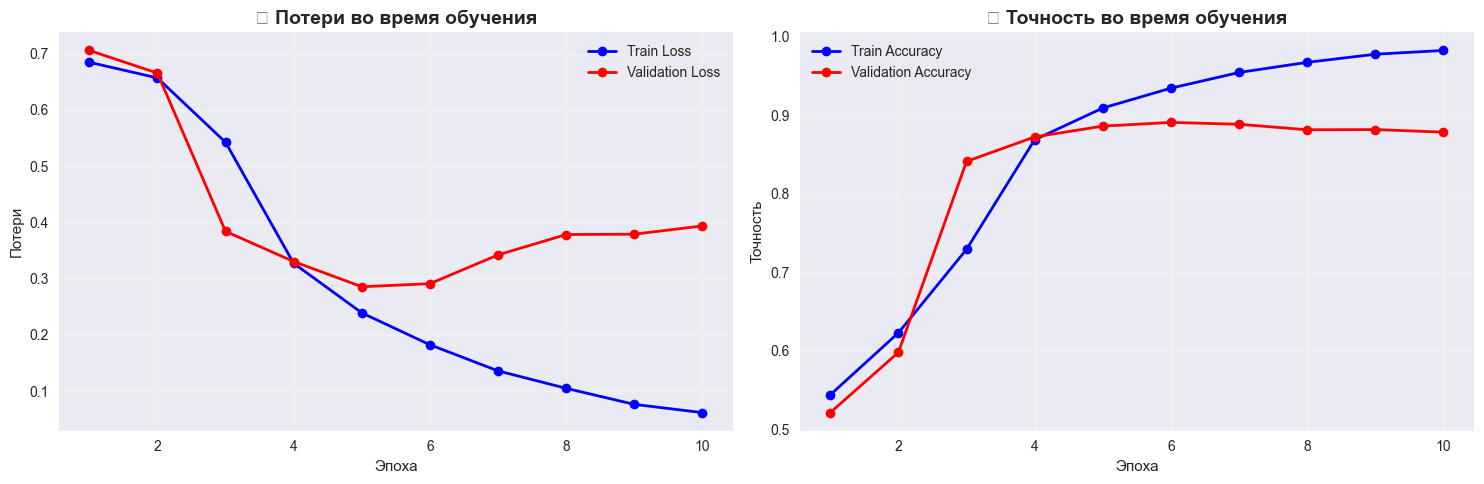

In [17]:
# Ячейка 16: Обучение модели
if df is not None:
    print("Запускаем обучение модели...")
    
    # Создание тренера
    trainer = SentimentTrainer(model, config.DEVICE)
    
    # Запуск обучения
    trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=config.EPOCHS,
        lr=config.LEARNING_RATE
    )
    
    # Визуализация процесса обучения
    trainer.plot_training_history(save_path="results/plots/training_history.png")

# %%

📊 Оценка модели на тестовой выборке...


 Результаты на тестовой выборке:
   Потери: 0.2864
   Точность: 0.8856 (88.56%)
 Confusion Matrix сохранена: results/plots/confusion_matrix.png


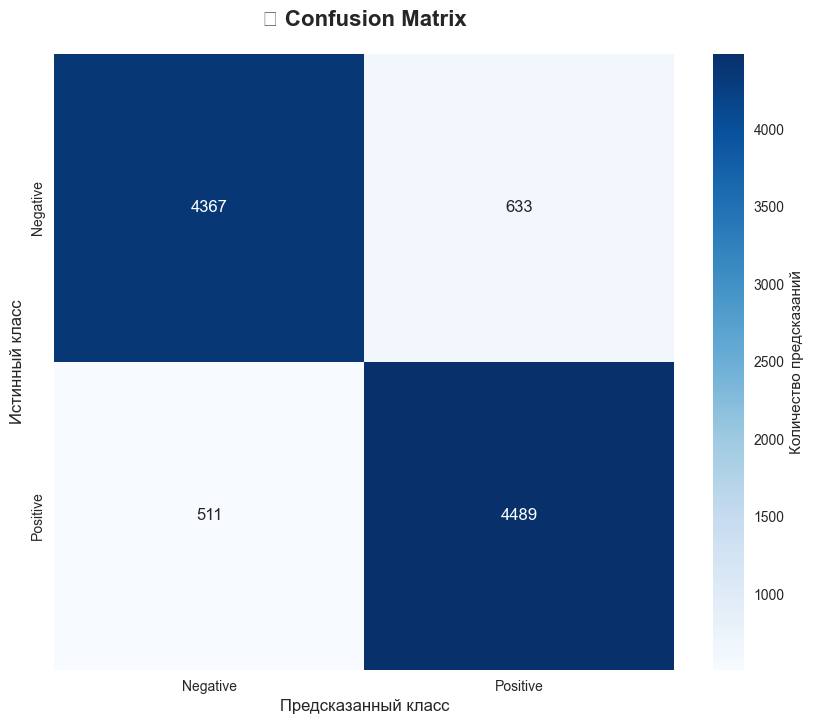


 Отчет о классификации:
              precision    recall  f1-score   support

    Negative     0.8952    0.8734    0.8842      5000
    Positive     0.8764    0.8978    0.8870      5000

    accuracy                         0.8856     10000
   macro avg     0.8858    0.8856    0.8856     10000
weighted avg     0.8858    0.8856    0.8856     10000

 Конфигурация модели сохранена: models/model_config.json


In [18]:
# Ячейка 17: Оценка модели на тестовой выборке
if df is not None:
    print("Оценка модели на тестовой выборке...")
    
    # Загрузка лучшей модели
    model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, map_location=config.DEVICE))
    
    # Тестирование
    criterion = nn.BCEWithLogitsLoss()
    test_loss, test_acc, test_preds, test_labels = trainer.evaluate(test_loader, criterion)
    
    print(f"   Результаты на тестовой выборке:")
    print(f"   Потери: {test_loss:.4f}")
    print(f"   Точность: {test_acc:.4f} ({test_acc*100:.2f}%)")
    
    # Детальный анализ предсказаний
    report = analyze_predictions(
        test_labels, 
        test_preds, 
        save_path="results/plots/confusion_matrix.png"
    )
    
    # Сохранение отчета
    with open("results/reports/classification_report.txt", "w") as f:
        f.write(report)
    
    # Сохранение метрик в JSON
    import json
    metrics = {
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "classification_report": report
    }
    
    with open("results/metrics/evaluation_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2, default=str)
    
    # Сохранение конфигурации модели
    save_model_config("models/model_config.json", model, preprocessor, metrics)

# %%

In [25]:
# Ячейка 18: Демонстрация работы модели
if df is not None:
    print("Демонстрация работы модели:")
    print("=" * 60)
    
    # Примеры для тестирования
    test_examples = [
        "This movie was absolutely fantastic! Great acting and amazing storyline.",
        "Terrible film, complete waste of time. Poor acting and boring plot.",
        "It was okay, not the best but not the worst movie I've seen.",
        "I didn't like it at all. Very disappointing and confusing.",
        "Amazing cinematography but the story was lacking depth.",
        "Best movie ever! Would definitely watch it again!",
        "Amazing!",
        "The worst movie I have ever seen in my entire life!"
    ]
    
    print(f"Предсказания модели:\n")
    
    for i, text in enumerate(test_examples, 1):
        sentiment, confidence = predict_sentiment(text, model, preprocessor, config.DEVICE)
        
        # Цветовая индикация
        color_emoji = "" if sentiment == "Positive" else ""
        confidence_bar = "█" * int(confidence * 10) + "░" * (10 - int(confidence * 10))
        
        print(f"{color_emoji} Пример {i}:")
        print(f"   Текст: '{text}'")
        print(f"   Предсказание: {sentiment}")
        print(f"   Уверенность: {confidence:.3f} [{confidence_bar}] {confidence*100:.1f}%")
        print()

# %%

 Демонстрация работы модели:
 Предсказания модели:

 Пример 1:
   Текст: 'This movie was absolutely fantastic! Great acting and amazing storyline.'
   Предсказание: Positive
   Уверенность: 0.988 [█████████░] 98.8%

 Пример 2:
   Текст: 'Terrible film, complete waste of time. Poor acting and boring plot.'
   Предсказание: Negative
   Уверенность: 0.990 [█████████░] 99.0%

 Пример 3:
   Текст: 'It was okay, not the best but not the worst movie I've seen.'
   Предсказание: Negative
   Уверенность: 0.936 [█████████░] 93.6%

 Пример 4:
   Текст: 'I didn't like it at all. Very disappointing and confusing.'
   Предсказание: Negative
   Уверенность: 0.983 [█████████░] 98.3%

 Пример 5:
   Текст: 'Amazing cinematography but the story was lacking depth.'
   Предсказание: Positive
   Уверенность: 0.659 [██████░░░░] 65.9%

 Пример 6:
   Текст: 'Best movie ever! Would definitely watch it again!'
   Предсказание: Positive
   Уверенность: 0.948 [█████████░] 94.8%

 Пример 7:
   Текст: 'Amazing!'
   

In [20]:
# Ячейка 19: Анализ ошибок модели
if df is not None:
    print("Анализ ошибок модели:")
    print("=" * 50)
    
    # Найдем примеры неправильных предсказаний
    wrong_predictions = []
    correct_predictions = []
    
    # Получим тексты тестовой выборки
    test_texts = test_df['review_cleaned'].tolist()
    
    for i, (true_label, pred_label) in enumerate(zip(test_labels, test_preds)):
        example = {
            'text': test_texts[i],
            'original_review': test_df.iloc[i]['review'],
            'true_label': 'Positive' if true_label == 1 else 'Negative',
            'pred_label': 'Positive' if pred_label == 1 else 'Negative',
            'text_length': len(test_texts[i].split())
        }
        
        if true_label != pred_label:
            wrong_predictions.append(example)
        else:
            correct_predictions.append(example)
    
    print(f" Количество ошибок: {len(wrong_predictions)} из {len(test_labels)} ({len(wrong_predictions)/len(test_labels)*100:.2f}%)")
    print(f" Правильных предсказаний: {len(correct_predictions)} ({len(correct_predictions)/len(test_labels)*100:.2f}%)")
    
    # Анализ типов ошибок
    false_positives = [ex for ex in wrong_predictions if ex['true_label'] == 'Negative' and ex['pred_label'] == 'Positive']
    false_negatives = [ex for ex in wrong_predictions if ex['true_label'] == 'Positive' and ex['pred_label'] == 'Negative']
    
    print(f"\n Типы ошибок:")
    print(f"   False Positives (Negative → Positive): {len(false_positives)}")
    print(f"   False Negatives (Positive → Negative): {len(false_negatives)}")
    
    # Примеры ошибок
    print(f"\n🔴 Примеры False Positives (модель думает 'положительный', а на самом деле 'отрицательный'):")
    for i, example in enumerate(false_positives[:3]):
        print(f"\nПример {i+1}:")
        print(f"Текст: {example['original_review'][:200]}...")
        print(f"Истинная метка: {example['true_label']}")
        print(f"Предсказание: {example['pred_label']}")
    
    print(f"\n🟡 Примеры False Negatives (модель думает 'отрицательный', а на самом деле 'положительный'):")
    for i, example in enumerate(false_negatives[:3]):
        print(f"\nПример {i+1}:")
        print(f"Текст: {example['original_review'][:200]}...")
        print(f"Истинная метка: {example['true_label']}")
        print(f"Предсказание: {example['pred_label']}")

# %%

 Анализ ошибок модели:
 Количество ошибок: 1144 из 10000 (11.44%)
 Правильных предсказаний: 8856 (88.56%)

 Типы ошибок:
   False Positives (Negative → Positive): 633
   False Negatives (Positive → Negative): 511

🔴 Примеры False Positives (модель думает 'положительный', а на самом деле 'отрицательный'):

Пример 1:
Текст: Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-"comment on everything that sucks and make the viewer feel better about their sucky teenage life" sitcom now muta...
Истинная метка: Negative
Предсказание: Positive

Пример 2:
Текст: The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwelle...
Истинная метка: Negative
Предсказание: Positive

Пример 3:
Текст: Little Quentin seems to have mastered the art of having the cake and eating it.<br /><br />As usual, the pure sadistic display can be ex